## Shorten the names of superoperator files

In [ ]:
import os
import shutil

folder = r'C:\Users\ssingh8\OneDrive - Delft University of Technology\SIMULATIONS DATA\direct_emission_scheme_simulations\direct_double_click_scheme\1_rates_at_98'

def copy_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith("merged.csv"):
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, "copy_" + filename)
            shutil.copy2(source, destination)

# for EM Distill WT4
def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.startswith("copy_"):
            bell_type = filename[filename.find("bell_pair_type-")+len("bell_pair_type-"):filename.rfind("_network_")]
            nn_type =  filename[filename.find("network_noise_type-")+len("network_noise_type-"):filename.rfind("_p_g")]
            set_parameters = filename[filename.find("hc_direct_ghz_node-")+len("hc_direct_ghz_node-"):filename.rfind("_bell_pair_type")]
            pg_val = float(filename[filename.find("p_g-")+len("p_g-"):filename.rfind("_p_m")])
            new_filename = filename.replace(filename, f"copy_{set_parameters}_bell_{bell_type}_nntype_{nn_type}_p_g-{pg_val}_p_m_.csv")
            source = os.path.join(directory, filename)
            destination = os.path.join(directory, new_filename)
            os.rename(source, destination)


copy_files(folder)
rename_files(folder)

# Comparison of various direct emission protocols

In [ ]:
from circuit_simulation.circuit_simulator import QuantumCircuit
# Set the Bell-state parameters
bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.02}

# Coherence parameters
# NeutralAtom1
# T2n_idle=10,T1n_idle=np.inf,T2n_link=10,T1n_link=np.inf,T2e_idle=10,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf
# NeutralAtom1EqualCoh (Set-3)
# T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10
# No-decoherence
# T2n_idle=np.inf,T1n_idle=np.inf,T2n_link=np.inf,T1n_link=np.inf,T2e_idle=np.inf,T1e_idle=np.inf,T2e_link=np.inf,T1e_link=np.inf

## Modeling of previous Bell-pair fusion scheme ($k=11$) with WT4 Set-3 FP 

Description of the fusion-distillation protocol:

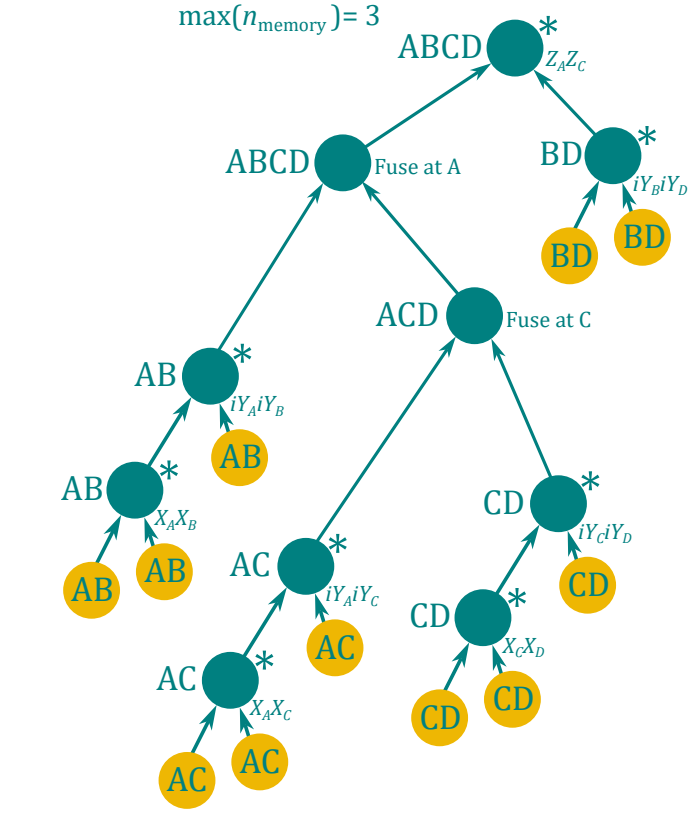

In [ ]:
from circuit_simulation.circuit_simulator import QuantumCircuit
import numpy as np
import scipy.sparse as sp
import cirq

class NewQuantumCircuit(QuantumCircuit):
    def _construct_noisy_bell_pair_state(self, bell_pair_parameters, network_noise_type=None, pg=None, *args, **kwargs):
        # Call the parent class's method to retain existing functionality
        super()._construct_noisy_bell_pair_state(*args, **kwargs)
        
        # Additonal modeling for decoherence based k=7 Bell pair fusion protocol

        # two qubit agte times
        two_qubit_times = 0.001

        if network_noise_type == 105:
            mu = bell_pair_parameters['mu']
            F_prep = bell_pair_parameters['F_prep']
            labda = bell_pair_parameters['lambda']
            p_DE = bell_pair_parameters['p_DE']
            eta = bell_pair_parameters['eta']
            alpha = bell_pair_parameters['alpha']
            bell_pair_protocol = bell_pair_parameters['ent_prot']

            weight = 4
            density_matrix_target = sp.lil_matrix((2**weight, 2**weight))
            density_matrix_target[0, 0] = 0.5
            density_matrix_target[0, 2**weight-1] = 0.5
            density_matrix_target[2**weight-1, 0] = 0.5
            density_matrix_target[2**weight-1, 2**weight-1] = 0.5

            double_click_bell_pair = np.zeros((4,4), dtype=complex)
            if self.photon_number_resolution is True:
                double_click_bell_pair[0,0] = (2 - 2*alpha + (-2 + pg)*pg*(1 + alpha*(-2 + eta)))/(4 + 2*(-2 + pg)*pg*eta + 2*alpha*(-2 + pg*(2 + pg*(-2 + eta)*eta)))
                double_click_bell_pair[0,3] = ((1 - 2*F_prep)**2*(1 - 2*p_DE)**4*(-1 + pg)**2*(-1 + alpha)*mu*(np.sqrt(1-mu) - np.sqrt(1+mu))*(np.sqrt(1-mu) + np.sqrt(1+mu)))/(4 + 2*(-2 + pg)*pg*eta + 2*alpha*(-2 + pg*(2 + pg*(-2 + eta)*eta)))
                double_click_bell_pair[2,2] = (pg*(pg + 2*(-1 + alpha) + pg*alpha*(-2 + eta))*(-1 + eta))/(2 + (-2 + pg)*pg*eta + alpha*(-2 + pg*(2 + pg*(-2 + eta)*eta)))
                double_click_bell_pair[3,0] = ((1 - 2*F_prep)**2*(1 - 2*p_DE)**4*(-1 + pg)**2*(-1 + alpha)*mu*(np.sqrt(1-mu) - np.sqrt(1+mu))*(np.sqrt(1-mu) + np.sqrt(1+mu)))/(4 + 2*(-2 + pg)*pg*eta + 2*alpha*(-2 + pg*(2 + pg*(-2 + eta)*eta)))
                double_click_bell_pair[3,3] = (2 - 2*alpha + (-2 + pg)*pg*(1 + alpha*(-2 + eta)))/(4 + 2*(-2 + pg)*pg*eta + 2*alpha*(-2 + pg*(2 + pg*(-2 + eta)*eta)))
                p_link_dc_bell = alpha*eta**2*(2 - 2*pg*eta + pg**2*eta + alpha*(-2 + 2*pg + pg**2*(-2 + eta)*eta))

            if self.photon_number_resolution is False:
                double_click_bell_pair[0,0] = (2*(8 - 8*alpha + (-2 + pg)*pg*(4 - alpha*(8 + eta*(-3 + mu)))))/(32 + alpha*(-32 + pg*(32 + pg*eta*(8 + eta*(-3 + mu))*(-3 + mu))) - 4*(-2 + pg)*pg*eta*(-3 + mu))
                double_click_bell_pair[0,3] = (-16*(1 - 2*F_prep)**2*(1 - 2*p_DE)**4*(-1 + pg)**2*(-1 + alpha)*mu)/(32 + alpha*(-32 + pg*(32 + pg*eta*(8 + eta*(-3 + mu))*(-3 + mu))) - 4*(-2 + pg)*pg*eta*(-3 + mu))
                double_click_bell_pair[2,2] = (pg*(8 - 8*alpha + pg*(-4 + alpha*(8 + eta*(-3 + mu))))*(4 + eta*(-3 + mu)))/(32 + alpha*(-32 + pg*(32 + pg*eta*(8 + eta*(-3 + mu))*(-3 + mu))) - 4*(-2 + pg)*pg*eta*(-3 + mu))
                double_click_bell_pair[3,0] = (-16*(1 - 2*F_prep)**2*(1 - 2*p_DE)**4*(-1 + pg)**2*(-1 + alpha)*mu)/(32 + alpha*(-32 + pg*(32 + pg*eta*(8 + eta*(-3 + mu))*(-3 + mu))) - 4*(-2 + pg)*pg*eta*(-3 + mu))
                double_click_bell_pair[3,3] = (2*(8 - 8*alpha + (-2 + pg)*pg*(4 - alpha*(8 + eta*(-3 + mu)))))/(32 + alpha*(-32 + pg*(32 + pg*eta*(8 + eta*(-3 + mu))*(-3 + mu))) - 4*(-2 + pg)*pg*eta*(-3 + mu))
                p_link_dc_bell = (alpha*eta**2*(32 + alpha*(-32 + 32*pg + pg**2*eta*(8 + eta*(-3 + mu))*(-3 + mu)) + 8*pg*eta*(-3 + mu) - 4*pg**2*eta*(-3 + mu)))/16
        
        # Each module has first qubit as communication qubit and others as memory qubits
        module_A = [cirq.LineQubit(i) for i in range(3)]  # {0,1,2}
        module_B = [cirq.LineQubit(i) for i in range(3, 5)] # {3,4}
        module_C = [cirq.LineQubit(i) for i in range(5, 8)] # {5,6,7}
        module_D = [cirq.LineQubit(i) for i in range(8, 10)] # {8,9}

        # Create a circuit for the Bell pair fusion protocol
        # Note that the branches for AB, AC, and CD fusion are the same so we can make one desnity matrix and use the same for all three branches
        
        t_CX = two_qubit_times
        t_CZ = two_qubit_times
        t_CiY = two_qubit_times

        pauli_operators = [cirq.I, cirq.X, cirq.Y, cirq.Z]

        # Define the two-qubit correlated gate noise channel function
        def correlated_two_qubit_noise_channel(p_g):
            kraus_ops = [np.sqrt(1 - p_g) * np.eye(4)]  # Identity term
            prob = p_g / 15

            for P_j in pauli_operators:
                for P_k in pauli_operators:
                    if P_j != cirq.I or P_k != cirq.I:  # Skip the (I, I) combination
                        kraus_op = np.sqrt(prob) * np.kron(P_j._unitary_(), P_k._unitary_())
                        kraus_ops.append(kraus_op)

            return kraus_ops
        
        def apply_correlated_two_qubit_noise_channel(p_g, qubits):
            return cirq.KrausChannel(correlated_two_qubit_noise_channel(p_g)).on(*qubits)


        simulator = cirq.DensityMatrixSimulator()
        # Step-1



In [ ]:
# Test the fusion protocol

## Improving coherence times

Coherence time:10
*** GHZ state fidelity of Raw state is 0.8839184183342568.***
*** Success probability of Raw state is 0.001540796087300688.***
*** GHZ state fidelity of DC direct emission state is 0.9343906766707759.***
*** Success probability of DC direct emission state is 0.0017068909160472075.***
*** GHZ state fidelity of the Basic protocol state is 0.6453009572807518.***
*** Success probability of the Basic protocol state is 9.629974089130609e-05.***
*** GHZ state fidelity of the W-state protocol state is 0.645300951053847.***
*** Success probability of the W-state protocol state is 0.00018911489855422033.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6453009848170945.***
*** Success probability of the Bell distillation protocol state is 0.00037223114031310764.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6453009736728712.***
*** Success probability of the Bell distillation protocol state is 0.0003793629197190894.***
Coherence ti

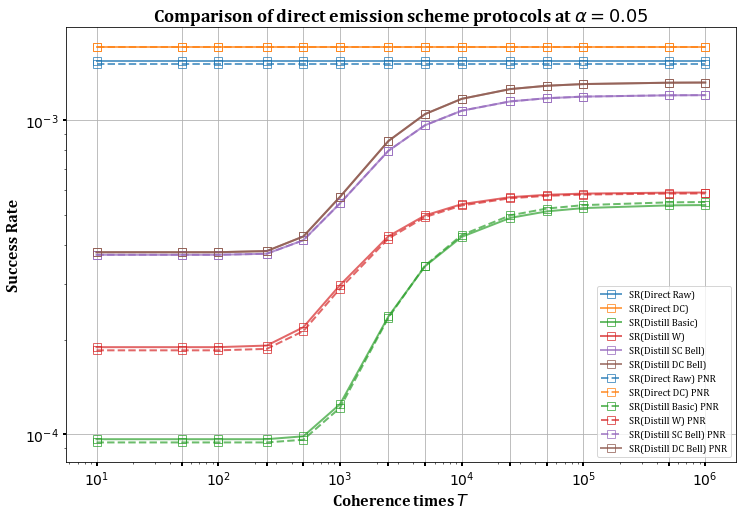

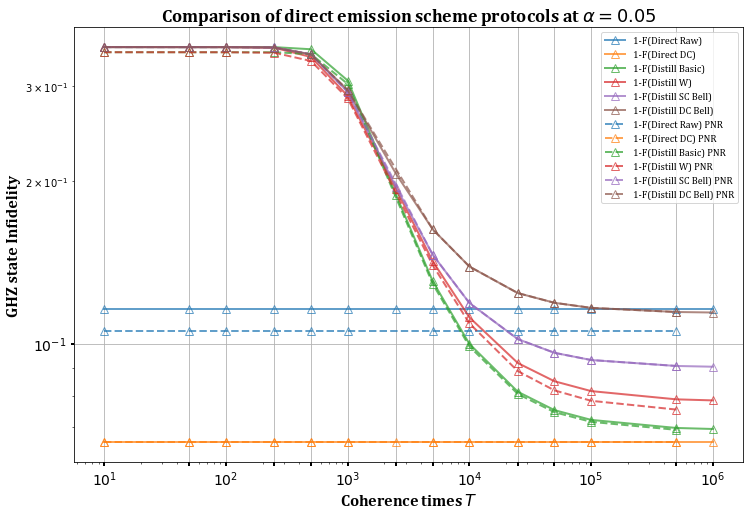

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Operating parameter alpha
alpha = 0.05

# Gate error in GHZ generation
pg = 0.001

# Coherence times improvement
coh_times = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 500000, 1000000]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []

for coh_time in coh_times:
    print(f"Coherence time:{coh_time}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=100, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.5}
    dc_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=101, photon_number_resolution=True,bell_pair_parameters=dc_bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=103, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=104, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = {"ent_prot":"double_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha} # Another bell pair protocol with double-click elemetray links
    bell_dc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

for coh_time in coh_times:
    print(f"Coherence time:{coh_time}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.5}
    dc_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=101, photon_number_resolution=True,bell_pair_parameters=dc_bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=103, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=104, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = {"ent_prot":"double_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha} # Another bell pair protocol with double-click elemetray links
    bell_dc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

ax.plot(coh_times, raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(coh_times, dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(coh_times, basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(coh_times, w_state_p, marker='s', color='#d62728', label='SR(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(coh_times, bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(coh_times, bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax.plot(coh_times, pnr_raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(coh_times, pnr_dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(coh_times, pnr_basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(coh_times, pnr_w_state_p, marker='s', color='#d62728', label='SR(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(coh_times, pnr_bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(coh_times, pnr_bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell) PNR', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax.grid(True)

# Set both x-axis and y-axis to log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set bold axis ticks and labels
ax.set_xticks(coh_times)
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Coherence times $T$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title(r'Comparison of direct emission scheme protocols at $\alpha=0.05$', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf)
coh_times_array = np.array(coh_times)  # Convert coh_times to a NumPy array
coh_times_filtered = coh_times_array[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf)
coh_times_filtered_pnr = coh_times_array[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]

ax_2.plot(coh_times_filtered, raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(coh_times_filtered, dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(coh_times_filtered, basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(coh_times_filtered, w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(coh_times_filtered, bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(coh_times_filtered, bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax_2.plot(coh_times_filtered_pnr, pnr_raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(coh_times_filtered_pnr, pnr_dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(coh_times_filtered_pnr, pnr_basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(coh_times_filtered_pnr, pnr_w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(coh_times_filtered_pnr, pnr_bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(coh_times_filtered_pnr, pnr_bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax_2.grid(True)

# Set both x-axis and y-axis to log scale
ax_2.set_xscale('log')
ax_2.set_yscale('log')

# Set bold axis ticks and labels
ax_2.set_xticks(coh_times)
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Coherence times $T$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title(r'Comparison of direct emission scheme protocols at $\alpha=0.05$', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()

# Save the plots as PDFs
fig.savefig('improving_coherence_times_success_rates.pdf', format='pdf', bbox_inches='tight')
fig_2.savefig('improving_coherence_times_infidelity.pdf', format='pdf', bbox_inches='tight')


## Hardware parameters' improvement

Bell-pair parameters Set-:{'ent_prot': 'single_click', 'F_prep': 0.999, 'p_DE': 0.01, 'mu': 0.95, 'lambda': 1, 'eta': 0.4474, 'alpha': 0.05}
*** GHZ state fidelity of Raw state is 0.8839184183342568.***
*** Success probability of Raw state is 0.001540796087300688.***
*** GHZ state fidelity of DC direct emission state is 0.9341302477553327.***
*** Success probability of DC direct emission state is 0.0017081763898064762.***
*** GHZ state fidelity of the Basic protocol state is 0.9305145872505711.***
*** Success probability of the Basic protocol state is 0.0005360630520846889.***
*** GHZ state fidelity of the W-state protocol state is 0.9214954608091723.***
*** Success probability of the W-state protocol state is 0.0005876288561414841.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.9093586530322463.***
*** Success probability of the Bell distillation protocol state is 0.0012000549059908215.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.8857

ValueError: The density matrix is not positive semidefinite.

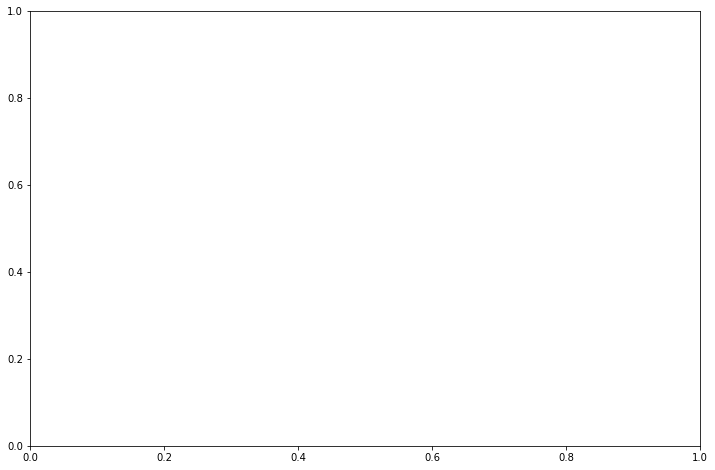

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit


# Coherence times improvement
coh_time = 1000000

# Operational point for alpha
alpha = 0.05

# Gate error in GHZ generation
pg = 0.001

# Bell-state parameters
bell_pair_parameters_list = [{"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.008,"mu":0.96,"lambda":1,"eta":0.62,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.006,"mu":0.97,"lambda":1,"eta":0.8,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.004,"mu":0.98,"lambda":1,"eta":0.9,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.0025,"mu":0.99,"lambda":1,"eta":0.95,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.001,"mu":0.99,"lambda":1,"eta":0.98,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.0,"mu":1,"lambda":1,"eta":0.99,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.0,"mu":1,"lambda":1,"eta":1,"alpha":alpha}]
x_positions = range(len(bell_pair_parameters_list))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []


pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []

for bell_pair_parameter_set in bell_pair_parameters_list:
    print(f"Bell-pair parameters Set-:{bell_pair_parameter_set}")
    raw_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=100, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = bell_pair_parameter_set.copy()
    dc_bell_pair_parameters["alpha"] = 0.5
    dc_state_qc = QuantumCircuit(1, pg=pg,network_noise_type=101, bell_pair_parameters=dc_bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=103, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=104, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameter_set.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

for bell_pair_parameter_set in bell_pair_parameters_list:
    print(f"Bell-pair parameters Set-:{bell_pair_parameter_set}")
    raw_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = bell_pair_parameter_set.copy()
    dc_bell_pair_parameters["alpha"] = 0.5
    dc_state_qc = QuantumCircuit(1, pg=pg,network_noise_type=101, bell_pair_parameters=dc_bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=103, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=104, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameter_set.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

ax.plot(x_positions, raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(x_positions, dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(x_positions, basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(x_positions, w_state_p, marker='s', color='#d62728', label='SR(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(x_positions, bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(x_positions, bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax.plot(x_positions, pnr_raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(x_positions, pnr_dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(x_positions, pnr_basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(x_positions, pnr_w_state_p, marker='s', color='#d62728', label='SR(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(x_positions, pnr_bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Direct SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(x_positions, pnr_bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax.grid(True)

# Set y-axis to log scale
# ax.set_xscale('log')
ax.set_yscale('log')

# Set bold axis ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels([f'ES-{i+1}' for i in x_positions], fontsize=12, fontweight='bold', fontdict={'family': 'Cambria'})
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Emission parameter sets', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title(rf'Comparison of direct emission scheme protocols for hardware sets at $\alpha={alpha}$, $T={coh_time}$, $p_g=${pg}', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf)
x_positions_array = np.array(x_positions)  # Convert x_positions to a NumPy array
x_positions_filtered = x_positions_array[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf)
x_positions_filtered_pnr = x_positions_array[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]

ax_2.plot(x_positions_filtered, raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(x_positions_filtered, dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(x_positions_filtered, basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(x_positions_filtered, w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(x_positions_filtered, bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(x_positions_filtered, bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax_2.plot(x_positions_filtered_pnr, pnr_raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(x_positions_filtered_pnr, pnr_dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(x_positions_filtered_pnr, pnr_basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(x_positions_filtered_pnr, pnr_w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(x_positions_filtered_pnr, pnr_bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(x_positions_filtered_pnr, pnr_bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax_2.grid(True)

# Set y-axis to log scale
# ax_2.set_xscale('log')
ax_2.set_yscale('log')

# Set bold axis ticks and labels
ax_2.set_xticks(x_positions)
ax_2.set_xticklabels([f'ES-{i+1}' for i in x_positions], fontsize=12, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Emission parameter sets', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title(rf'Comparison of direct emission scheme protocols for hardware sets at $\alpha={alpha}$, $T={coh_time}$, $p_g=${pg}', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()

# Save the plots as PDFs
fig.savefig('hardware_parameters_improvement_success_rates.pdf', format='pdf', bbox_inches='tight')
fig_2.savefig('hardware_parameters_improvement_infidelity.pdf', format='pdf', bbox_inches='tight')

## Double-excitation error influence

p_DE:0.01
*** GHZ state fidelity of Raw state is 0.9075269949527324.***
*** Success probability of Raw state is 0.0015120605602767217.***
*** GHZ state fidelity of DC direct emission state is 0.9463563430284707.***
*** Success probability of DC direct emission state is 0.0017714808151082125.***
*** GHZ state fidelity of the Basic protocol state is 0.6579434262936651.***
*** Success probability of the Basic protocol state is 9.450370846446271e-05.***
*** GHZ state fidelity of the W-state protocol state is 0.6579434314040533.***
*** Success probability of the W-state protocol state is 0.00018565045885978658.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6579434321060278.***
*** Success probability of the Bell distillation protocol state is 0.0003655196811259243.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6579434243089743.***
*** Success probability of the Bell distillation protocol state is 0.0003723927676282203.***
p_DE:0.008
*** GHZ 

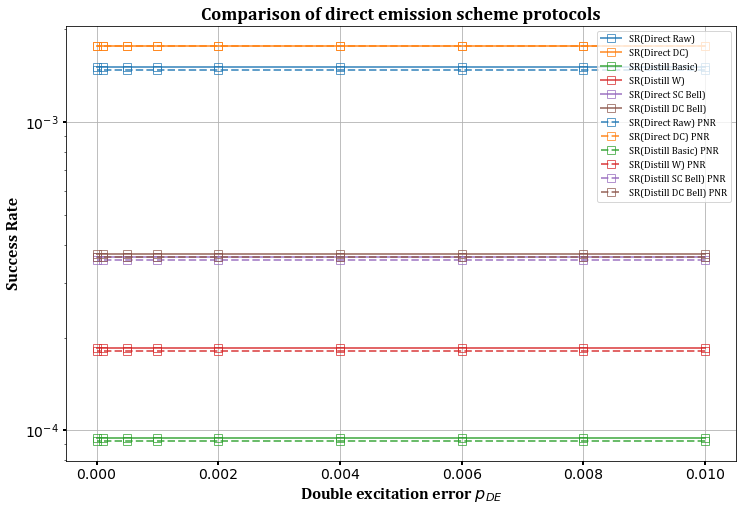

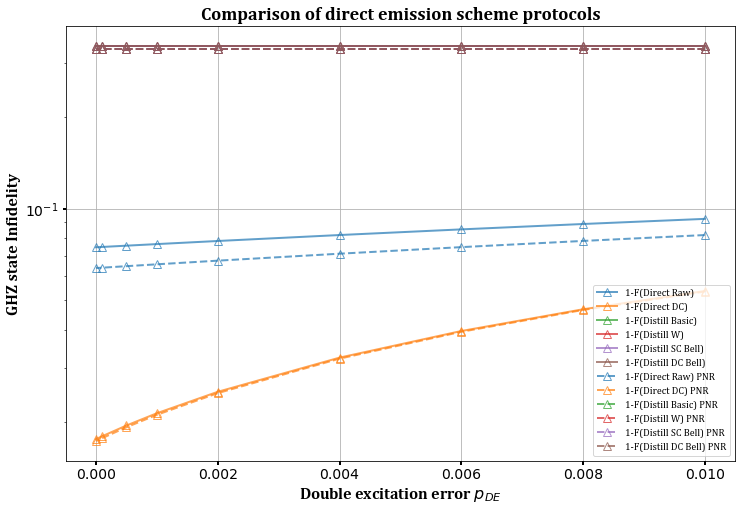

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit


p_DE = [0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0.0005, 0.0001, 0.0]

# Bright State parameter alpha
alpha = 0.05

# Coherence times
coh_time = 10 # Set-3

# Gate error in GHZ generation
pg = 0.001

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []

for pDE in p_DE:
    print(f"p_DE:{pDE}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":pDE,"mu":0.97,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=100, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = bell_pair_parameters.copy()
    dc_bell_pair_parameters["alpha"] = 0.5
    dc_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=101, bell_pair_parameters=dc_bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=103, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=104, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

for pDE in p_DE:
    print(f"p_DE:{pDE}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":pDE,"mu":0.97,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = bell_pair_parameters.copy()
    dc_bell_pair_parameters["alpha"] = 0.5
    dc_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=101, photon_number_resolution=True,bell_pair_parameters=dc_bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=103, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=104, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1,pg=pg,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)


ax.plot(p_DE, raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(p_DE, dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(p_DE, basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(p_DE, w_state_p, marker='s', color='#d62728', label='SR(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(p_DE, bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Direct SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(p_DE, bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax.plot(p_DE, pnr_raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(p_DE, pnr_dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(p_DE, pnr_basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(p_DE, pnr_w_state_p, marker='s', color='#d62728', label='SR(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(p_DE, pnr_bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(p_DE, pnr_bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax.grid(True)

# Set axis to log scale
ax.set_yscale('log')

# Set bold axis ticks and labels
# ax.set_xticks(p_DE)
# ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Double excitation error $p_{DE}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf)
p_DE_filtered = np.array(p_DE)[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf)
p_DE_filtered_pnr = np.array(p_DE)[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]

ax_2.plot(p_DE_filtered, raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(p_DE_filtered, dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(p_DE_filtered, basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(p_DE_filtered, w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(p_DE_filtered, bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(p_DE_filtered, bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax_2.plot(p_DE_filtered_pnr, pnr_raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(p_DE_filtered_pnr, pnr_dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(p_DE_filtered_pnr, pnr_basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(p_DE_filtered_pnr, pnr_w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(p_DE_filtered_pnr, pnr_bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(p_DE_filtered_pnr, pnr_bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax_2.grid(True)

# Set axis to log scale
ax_2.set_yscale('log')

# Set bold axis ticks and labels
# ax_2.set_xticks(p_DE)
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Double excitation error $p_{DE}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize


# Show the plot
plt.show()

# Save the figure as PDF
fig.savefig('double_excitation_error_influence_success_rates.pdf', bbox_inches='tight', dpi=300)
fig_2.savefig('double_excitation_error_influence_infidelity.pdf', bbox_inches='tight', dpi=300)


## Heatmaps for hardware and coherence parameters for the performance

In [6]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
import matplotlib.pyplot as plt

# Bright state parameter alpha
alpha = 0.05

# Gate error in GHZ state
pg = 0.001

# Define the coherence times and Bell pair parameter sets
coh_times = [10, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 500000, 1000000]
# coh_times = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000]
# coh_times = [10, 50, 100]
bell_pair_parameters_list = [
    {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": 0.4474, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.008, "mu": 0.96, "lambda": 1, "eta": 0.62, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.006, "mu": 0.97, "lambda": 1, "eta": 0.8, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.004, "mu": 0.98, "lambda": 1, "eta": 0.9, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.002, "mu": 0.99, "lambda": 1, "eta": 0.95, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.001, "mu": 0.99, "lambda": 1, "eta": 0.98, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.0, "mu": 1, "lambda": 1, "eta": 0.99, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.0, "mu": 1, "lambda": 1, "eta": 1, "alpha": alpha}
]

# Initialize matrices to store infidelity and success probability values for each protocol
protocols = ["Direct Raw", "Direct DC", "Distill Basic", "Distill W", "Distill SC Bell", "Distill DC Bell"]
infidelity_data = {protocol: np.zeros((len(coh_times), len(bell_pair_parameters_list))) for protocol in protocols}
success_rate_data = {protocol: np.zeros((len(coh_times), len(bell_pair_parameters_list))) for protocol in protocols}

# Loop over the coherence times, Bell pair parameter sets, and protocols
for i, coh_time in enumerate(coh_times):
    for j, bell_pair_parameters in enumerate(bell_pair_parameters_list):
        for protocol in protocols:
            # Set alpha=0.5 only for the "Direct DC" protocol
            if protocol == "Direct DC":
                bell_pair_parameters["alpha"] = 0.5
            elif protocol != "Direct DC":
                bell_pair_parameters["alpha"] = alpha
            if protocol == "Distill DC Bell":
                bell_pair_parameters["ent_prot"] = "double_click"
            elif protocol != "Distill DC Bell":
                bell_pair_parameters["ent_prot"] = "single_click"
            print(f"Coherence time: {coh_time}, Bell pair parameters: {bell_pair_parameters}, Protocol: {protocol}")
            network_noise_type = {
                "Direct Raw": 100,
                "Direct DC": 101,
                "Distill Basic": 103,
                "Distill W": 104,
                "Distill SC Bell": 102,
                "Distill DC Bell": 102
            }[protocol]
            qc = QuantumCircuit(1, pg=pg,network_noise_type=network_noise_type, bell_pair_parameters=bell_pair_parameters,
                                T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time,
                                T2e_idle=coh_time, T1e_idle=coh_time)
            infidelity_data[protocol][i, j] = 1 - qc.F_link
            success_rate_data[protocol][i, j] = qc.p_link



Coherence time: 10, Bell pair parameters: {'ent_prot': 'single_click', 'F_prep': 0.999, 'p_DE': 0.01, 'mu': 0.95, 'lambda': 1, 'eta': 0.4474, 'alpha': 0.05}, Protocol: Direct Raw
*** GHZ state fidelity of Raw state is 0.8839184183342568.***
*** Success probability of Raw state is 0.001540796087300688.***
Coherence time: 10, Bell pair parameters: {'ent_prot': 'single_click', 'F_prep': 0.999, 'p_DE': 0.01, 'mu': 0.95, 'lambda': 1, 'eta': 0.4474, 'alpha': 0.5}, Protocol: Direct DC
*** GHZ state fidelity of DC direct emission state is 0.9341302477553327.***
*** Success probability of DC direct emission state is 0.0017081763898064762.***
Coherence time: 10, Bell pair parameters: {'ent_prot': 'single_click', 'F_prep': 0.999, 'p_DE': 0.01, 'mu': 0.95, 'lambda': 1, 'eta': 0.4474, 'alpha': 0.05}, Protocol: Distill Basic
*** GHZ state fidelity of the Basic protocol state is 0.6453009572807518.***
*** Success probability of the Basic protocol state is 9.629974089130609e-05.***
Coherence time: 10,

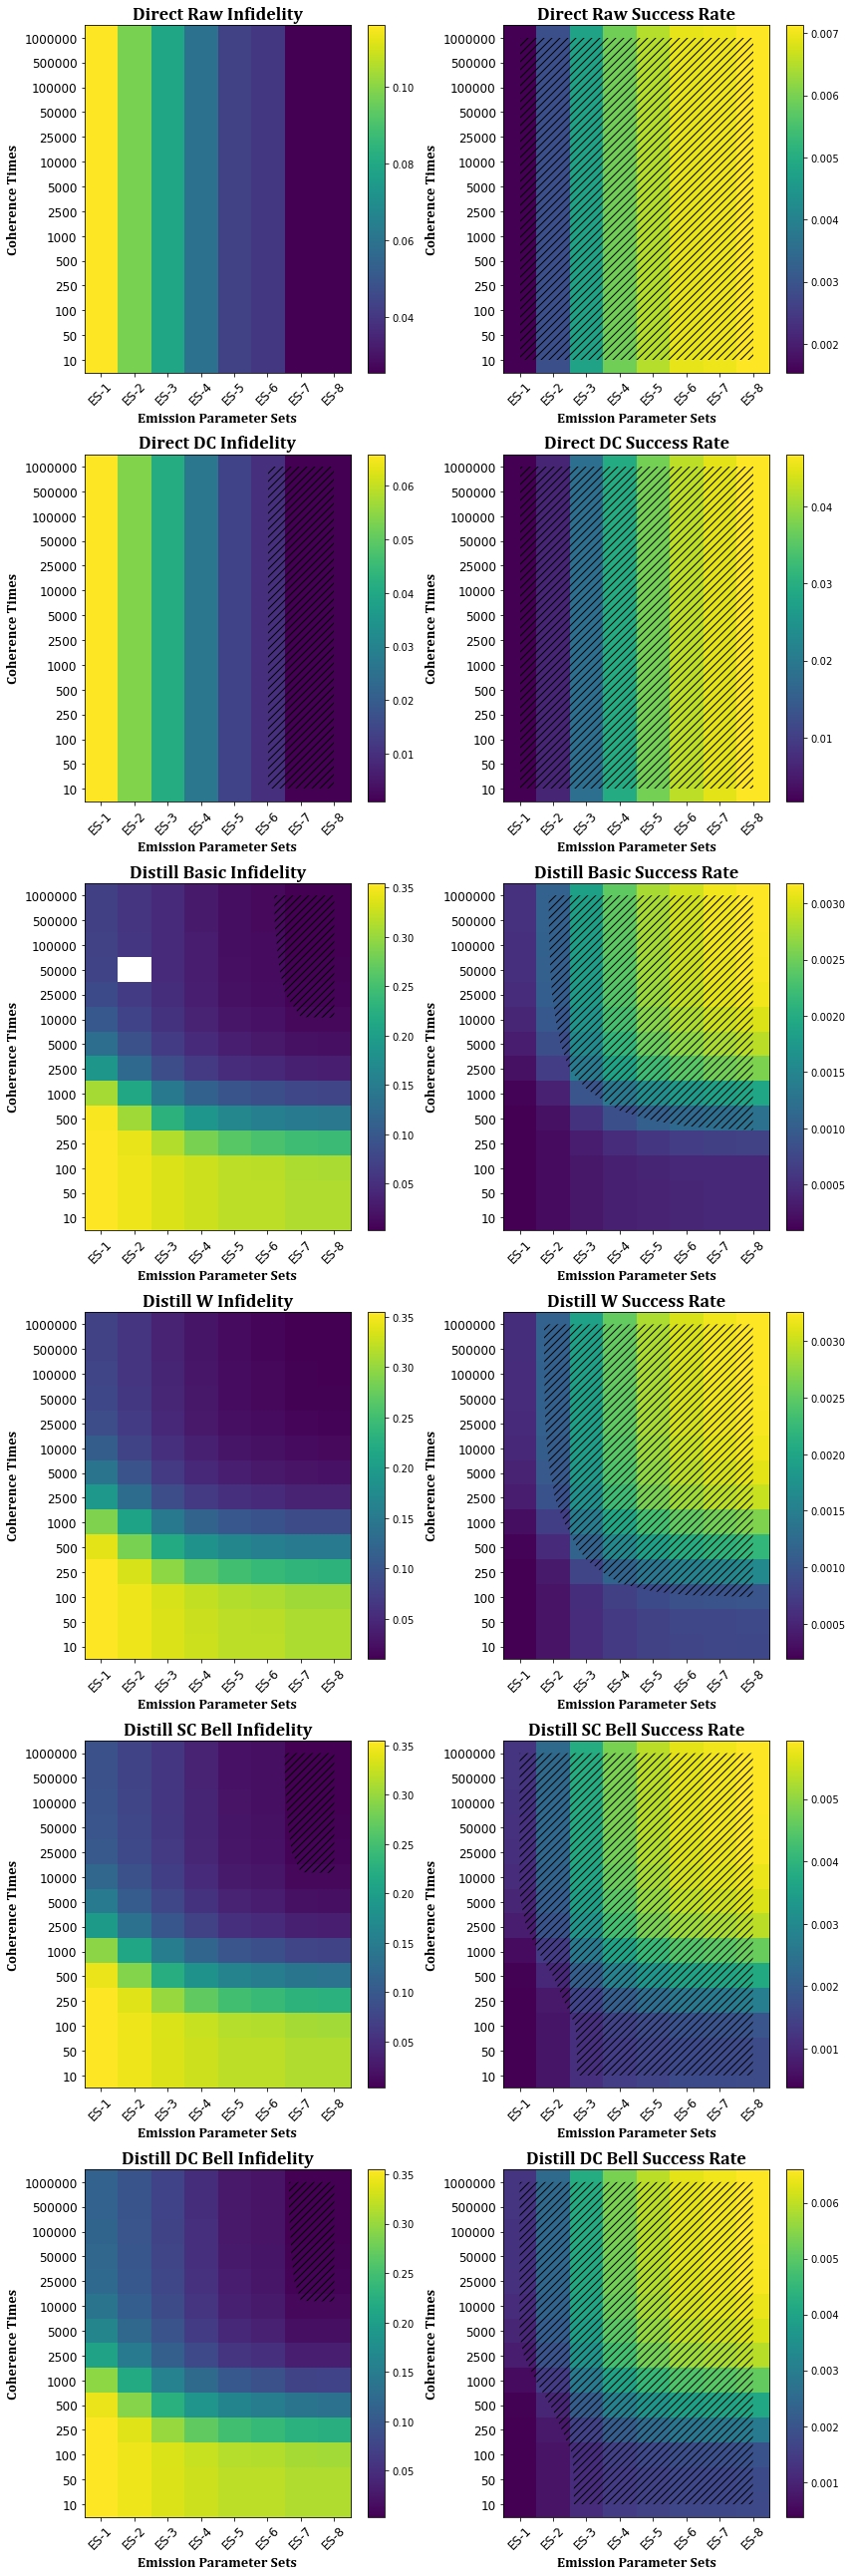

In [22]:
import matplotlib.pyplot as plt

# Reverse the coherence times for proper ordering
reversed_coh_times = coh_times[::-1]

# Plot heatmaps for infidelity and success rates
fig, axs = plt.subplots(len(protocols), 2, figsize=(12, 6 * len(protocols)))

# Set the background color to white
fig.patch.set_facecolor('white')

for idx, protocol in enumerate(protocols):
    # Infidelity heatmap
    axs[idx, 0].set_facecolor('white')
    im1 = axs[idx, 0].imshow(infidelity_data[protocol][::-1], aspect='auto', cmap='viridis')
    axs[idx, 0].set_title(f'{protocol} Infidelity', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 18})
    axs[idx, 0].set_xlabel('Emission Parameter Sets', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    axs[idx, 0].set_ylabel('Coherence Times', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    axs[idx, 0].set_xticks(range(len(bell_pair_parameters_list)))
    axs[idx, 0].set_xticklabels([f'ES-{i+1}' for i in range(len(bell_pair_parameters_list))], rotation=45)
    axs[idx, 0].set_yticks(range(len(reversed_coh_times)))
    axs[idx, 0].set_yticklabels(reversed_coh_times)
    fig.colorbar(im1, ax=axs[idx, 0])

    # Shade region where infidelity <= 1e-2
    axs[idx, 0].contourf(
        infidelity_data[protocol][::-1],
        levels=[0, 1e-2],
        hatches=['///'],
        colors='red',
        alpha=0
    )

    # Success rate heatmap
    axs[idx, 1].set_facecolor('white')
    im2 = axs[idx, 1].imshow(success_rate_data[protocol][::-1], aspect='auto', cmap='viridis')
    axs[idx, 1].set_title(f'{protocol} Success Rate', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 18})
    axs[idx, 1].set_xlabel('Emission Parameter Sets', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    axs[idx, 1].set_ylabel('Coherence Times', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    axs[idx, 1].set_xticks(range(len(bell_pair_parameters_list)))
    axs[idx, 1].set_xticklabels([f'ES-{i+1}' for i in range(len(bell_pair_parameters_list))], rotation=45)
    axs[idx, 1].set_yticks(range(len(reversed_coh_times)))
    axs[idx, 1].set_yticklabels(reversed_coh_times)
    fig.colorbar(im2, ax=axs[idx, 1])

    # Shade region where success rate >= 1e-3
    axs[idx, 1].contourf(
        success_rate_data[protocol][::-1],
        levels=[1e-3, success_rate_data[protocol].max()],
        hatches=['///'],
        colors='red',
        alpha=0
    )

plt.tight_layout()
plt.show()

# Save the figure as PDF
fig.savefig('heatmap_hardware_coherence_parameters.pdf', format='pdf', bbox_inches='tight')


## Bright state parameter influence

alpha:0.0101
*** GHZ state fidelity of Raw state is 0.9373839870552994.***
*** Success probability of Raw state is 6.279013347374761e-05.***
*** GHZ state fidelity of DC direct emission state is 0.946617212757673.***
*** Success probability of DC direct emission state is 2.8299420383084513e-06.***
*** GHZ state fidelity of the Basic protocol state is 0.6795625901968056.***
*** Success probability of the Basic protocol state is 3.924383898352112e-06.***
*** GHZ state fidelity of the W-state protocol state is 0.6795625783037547.***
*** Success probability of the W-state protocol state is 7.82121881687123e-06.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6795625966129561.***
*** Success probability of the Bell distillation protocol state is 1.5588976295505574e-05.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6795625901855715.***
*** Success probability of the Bell distillation protocol state is 1.5687699414036037e-05.***
alpha:0.0601
***

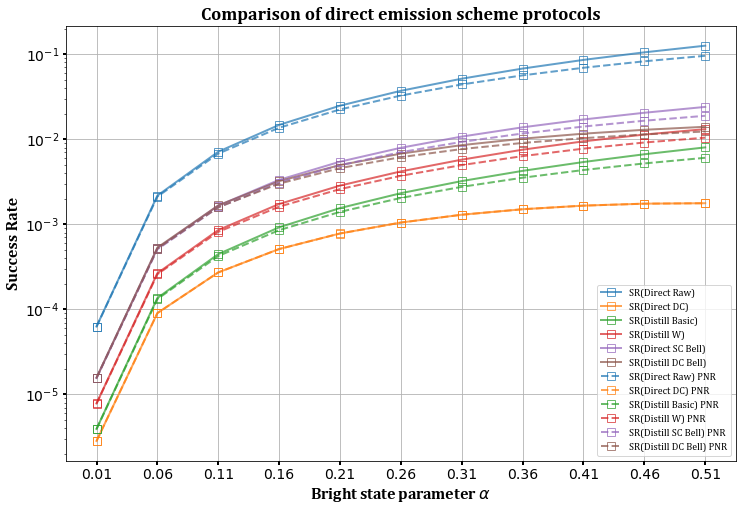

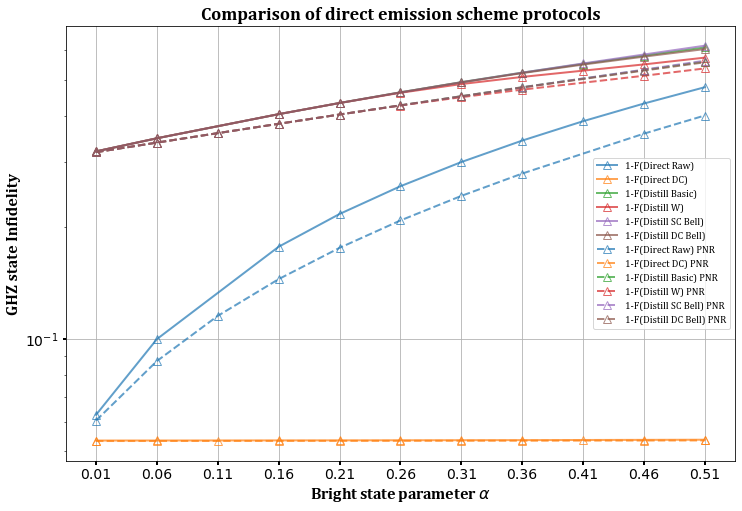

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Bright State parameter alpha
alpha_range = np.arange(0.0101, 0.55, 0.05)

# Coherence times
coh_time = 10 # Set-3

# Gate error in GHZ state
pg = 0.001

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []

for alpha in alpha_range:
    print(f"alpha:{alpha}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":0.01,"mu":0.97,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,network_noise_type=104, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

for alpha in alpha_range:
    print(f"alpha:{alpha}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":0.01,"mu":0.97,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(1,network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(1,network_noise_type=101, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(1,network_noise_type=103, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)

    w_distilled_state_qc = QuantumCircuit(1,network_noise_type=104, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)

    bell_sc_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1,network_noise_type=102, photon_number_resolution=True,bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)


ax.plot(alpha_range, raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(alpha_range, dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(alpha_range, basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(alpha_range, w_state_p, marker='s', color='#d62728', label='SR(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(alpha_range, bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Direct SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(alpha_range, bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax.plot(alpha_range, pnr_raw_p, marker='s', color='#1f77b4', label='SR(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(alpha_range, pnr_dc_state_p, marker='s', color='#ff7f0e', label='SR(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(alpha_range, pnr_basic_state_p, marker='s', color='#2ca02c', label='SR(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(alpha_range, pnr_w_state_p, marker='s', color='#d62728', label='SR(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(alpha_range, pnr_bell_sc_distilled_state_p, marker='s', color='#9467bd', label='SR(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(alpha_range, pnr_bell_dc_distilled_state_p, marker='s', color='#8c564b', label='SR(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax.grid(True)

# Set y-axis to log scale
ax.set_yscale('log')

# Set bold axis ticks and labels
ax.set_xticks(alpha_range)
ax.set_xticklabels([f'{alpha:.2f}' for alpha in alpha_range])
# ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Bright state parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf)
alpha_filtered = np.array(alpha_range)[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf)
alpha_filtered_pnr = np.array(alpha_range)[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]

ax_2.plot(alpha_filtered, raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(alpha_filtered, dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(alpha_filtered, basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(alpha_filtered, w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(alpha_filtered, bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(alpha_filtered, bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax_2.plot(alpha_filtered_pnr, pnr_raw_inf_filtered, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(alpha_filtered_pnr, pnr_dc_state_inf_filtered, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(alpha_filtered_pnr, pnr_basic_state_inf_filtered, marker='^', color='#2ca02c', label='1-F(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(alpha_filtered_pnr, pnr_w_state_inf_filtered, marker='^', color='#d62728', label='1-F(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(alpha_filtered_pnr, pnr_bell_sc_distilled_state_inf_filtered, marker='^', color='#9467bd', label='1-F(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(alpha_filtered_pnr, pnr_bell_dc_distilled_state_inf_filtered, marker='^', color='#8c564b', label='1-F(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax_2.grid(True)

# Set y-axis to log scale
ax_2.set_yscale('log')

# Set bold axis ticks and labels
ax_2.set_xticks(alpha_range)
ax_2.set_xticklabels([f'{alpha:.2f}' for alpha in alpha_range])
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Bright state parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize


# Show the plot
plt.show()

# Save the figures as PDFs
fig.savefig('bright_state_parameter_influence_success_rates.pdf', bbox_inches='tight', dpi=300)
fig_2.savefig('bright_state_parameter_influence_infidelity.pdf', bbox_inches='tight', dpi=300)


## Effective photon detection probability influence

eta:0.001
*** GHZ state fidelity of Raw state is 0.9020462283960564.***
*** Success probability of Raw state is 1.2584759130409765e-09.***
*** GHZ state fidelity of DC direct emission state is 0.9342469721139242.***
*** Success probability of DC direct emission state is 2.6181474867586644e-16.***
*** GHZ state fidelity of the Basic protocol state is 0.658518043598349.***
*** Success probability of the Basic protocol state is 7.865474629340832e-11.***
*** GHZ state fidelity of the W-state protocol state is 0.658518058976603.***
*** Success probability of the W-state protocol state is 1.5730699698889419e-10.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6585180257002334.***
*** Success probability of the Bell distillation protocol state is 3.1383009290168773e-10.***
*** GHZ state fidelity of the Bell distillation protocol state is 0.6585180257002334.***
*** Success probability of the Bell distillation protocol state is 3.1383009290168773e-10.***
*** GHZ state fid

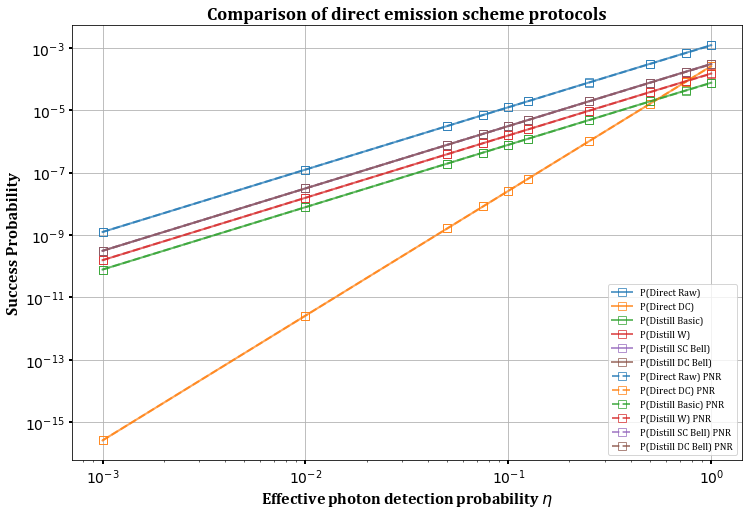

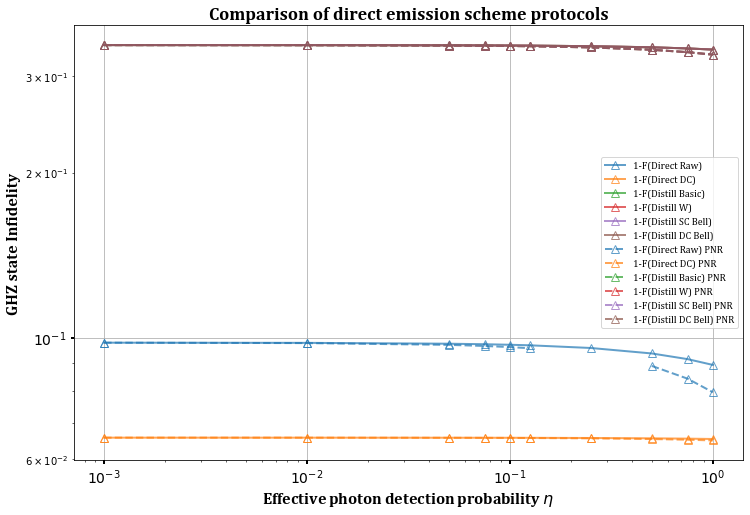

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from circuit_simulation.circuit_simulator import QuantumCircuit

# Effective photon detection probability eta
eta = np.array([1e-3, 1e-2, 0.05, 0.075, 1e-1, 0.125, 0.25, 0.5, 0.75, 1.0])

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
w_state_p = []
w_state_inf = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []

for eta_val in eta:
    print(f"eta:{eta_val}")
    bell_pair_parameters = {"ent_prot": "double_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": eta_val, "alpha": 0.02}
    
    raw_state_qc = QuantumCircuit(1, network_noise_type=100, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)
    
    dc_state_qc = QuantumCircuit(1, network_noise_type=101, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)
    
    basic_distilled_state_qc = QuantumCircuit(1, network_noise_type=103, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    
    w_distilled_state_qc = QuantumCircuit(1, network_noise_type=104, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)
    
    bell_sc_distilled_state_qc = QuantumCircuit(1, network_noise_type=102, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(1, network_noise_type=102, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)

    # PNR scenario
    raw_state_qc_pnr = QuantumCircuit(1, network_noise_type=100, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    pnr_raw_p.append(raw_state_qc_pnr.p_link)
    pnr_raw_inf.append(1-raw_state_qc_pnr.F_link)
    
    dc_state_qc_pnr = QuantumCircuit(1, network_noise_type=101, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    pnr_dc_state_p.append(dc_state_qc_pnr.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc_pnr.F_link)
    
    basic_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=103, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    pnr_basic_state_p.append(basic_distilled_state_qc_pnr.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc_pnr.F_link)
    
    w_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=104, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    pnr_w_state_p.append(w_distilled_state_qc_pnr.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc_pnr.F_link)
    
    bell_sc_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=102, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc_pnr.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc_pnr.F_link)

    bell_dc_distilled_state_qc_pnr = QuantumCircuit(1, network_noise_type=102, photon_number_resolution=True, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=10,T1n_idle=10,T2n_link=10,T1n_link=10,T2e_idle=10,T1e_idle=10)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc_pnr.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc_pnr.F_link)


ax.plot(eta, raw_p, marker='s', color='#1f77b4', label='P(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(eta, dc_state_p, marker='s', color='#ff7f0e', label='P(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(eta, basic_state_p, marker='s', color='#2ca02c', label='P(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(eta, w_state_p, marker='s', color='#d62728', label='P(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(eta, bell_sc_distilled_state_p, marker='s', color='#9467bd', label='P(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(eta, bell_dc_distilled_state_p, marker='s', color='#8c564b', label='P(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax.plot(eta, pnr_raw_p, marker='s', color='#1f77b4', label='P(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax.plot(eta, pnr_dc_state_p, marker='s', color='#ff7f0e', label='P(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax.plot(eta, pnr_basic_state_p, marker='s', color='#2ca02c', label='P(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax.plot(eta, pnr_w_state_p, marker='s', color='#d62728', label='P(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax.plot(eta, pnr_bell_sc_distilled_state_p, marker='s', color='#9467bd', label='P(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax.plot(eta, pnr_bell_dc_distilled_state_p, marker='s', color='#8c564b', label='P(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax.grid(True)

# Set axis to log scale
ax.set_yscale('log')
ax.set_xscale('log')

# Set bold axis ticks and labels
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Effective photon detection probability $\eta$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Probability', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTS

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

# Plot the curves with specified markers and colors
ax_2.plot(eta, raw_inf, marker='^', color='#1f77b4', label='1-F(Direct Raw)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(eta, dc_state_inf, marker='^', color='#ff7f0e', label='1-F(Direct DC)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(eta, basic_state_inf, marker='^', color='#2ca02c', label='1-F(Distill Basic)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(eta, w_state_inf, marker='^', color='#d62728', label='1-F(Distill W)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(eta, bell_sc_distilled_state_inf, marker='^', color='#9467bd', label='1-F(Distill SC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(eta, bell_dc_distilled_state_inf, marker='^', color='#8c564b', label='1-F(Distill DC Bell)', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

ax_2.plot(eta, pnr_raw_inf, marker='^', color='#1f77b4', label='1-F(Direct Raw) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Blue
ax_2.plot(eta, pnr_dc_state_inf, marker='^', color='#ff7f0e', label='1-F(Direct DC) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Orange
ax_2.plot(eta, pnr_basic_state_inf, marker='^', color='#2ca02c', label='1-F(Distill Basic) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Green
ax_2.plot(eta, pnr_w_state_inf, marker='^', color='#d62728', label='1-F(Distill W) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Red
ax_2.plot(eta, pnr_bell_sc_distilled_state_inf, marker='^', color='#9467bd', label='1-F(Distill SC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Purple
ax_2.plot(eta, pnr_bell_dc_distilled_state_inf, marker='^', color='#8c564b', label='1-F(Distill DC Bell) PNR', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Brown

# Enable grid
ax_2.grid(True)

# Set axis to log scale
ax_2.set_yscale('log')
ax_2.set_xscale('log')

# Set bold axis ticks and labels
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Effective photon detection probability $\eta$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize



# Show the plot
plt.show()

# Save the figures as PDFs
fig.savefig('eta_influence_success_rates.pdf', bbox_inches='tight', dpi=300)
fig_2.savefig('eta_influence_infidelity.pdf', bbox_inches='tight', dpi=300)

## Bright state preparation parameters for raw and distillation resource

alpha:0.0010101, alpha_distill:0.0010101
*** GHZ state fidelity of the Bell distillation protocol state is 0.6714010088058315.***
*** Success probability of the Bell distillation protocol state is 1.6045655972781717e-07.***
*** GHZ state fidelity of the Basic protocol state is 0.6714010338135185.***
*** Success probability of the Basic protocol state is 4.0142665677110356e-08.***
*** GHZ state fidelity of the W-state protocol state is 0.6714010105219861.***
*** Success probability of the W-state protocol state is 8.025672659197322e-08.***
alpha:0.0010101, alpha_distill:0.1010101
*** GHZ state fidelity of the Bell distillation protocol state is 0.6714010197197094.***
*** Success probability of the Bell distillation protocol state is 1.6056949340124438e-07.***
*** GHZ state fidelity of the Basic protocol state is 0.6714010299581776.***
*** Success probability of the Basic protocol state is 8.027694283314652e-08.***
*** GHZ state fidelity of the W-state protocol state is 0.671401012874673

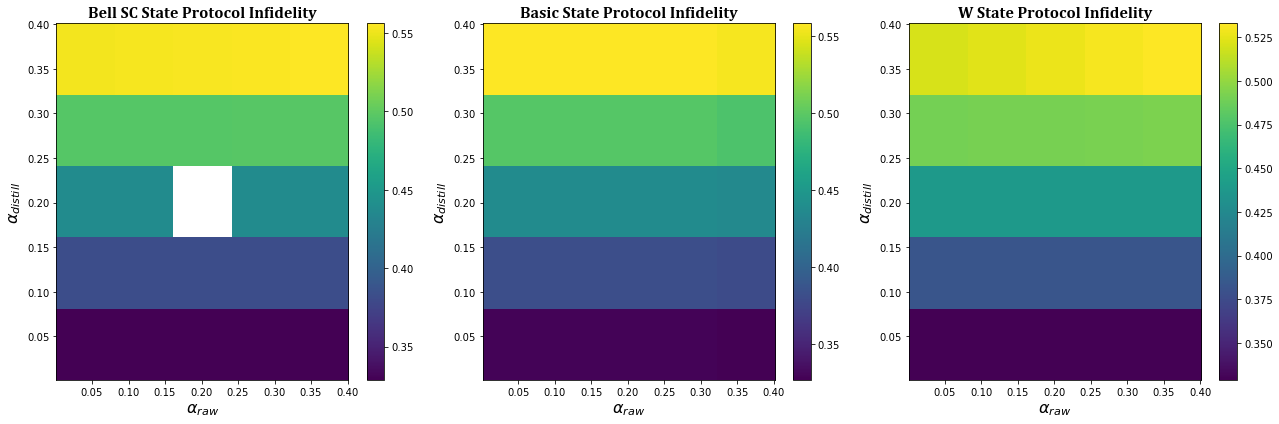

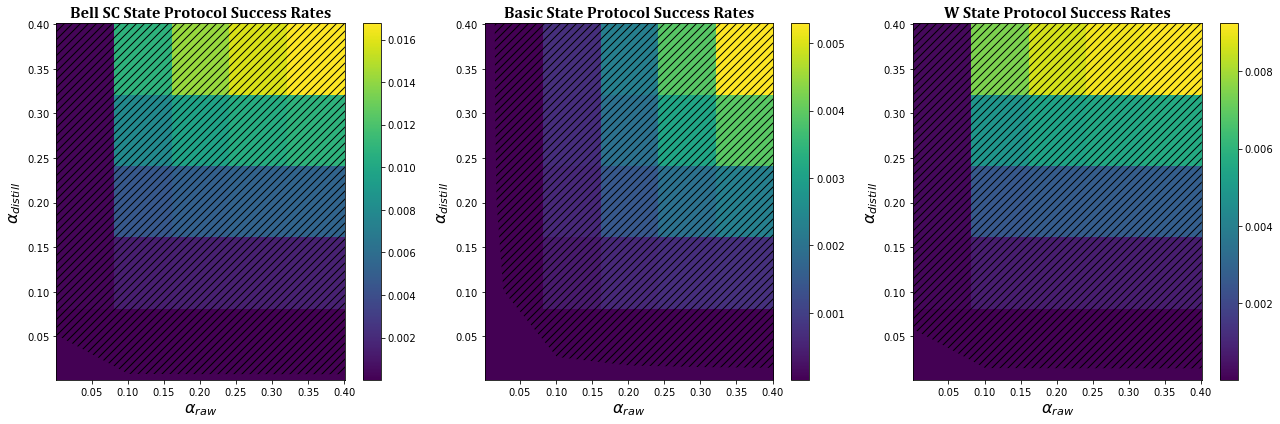

In [27]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
import matplotlib.pyplot as plt

# Coherence times
coh_time = 10  # Coherence times

# Gate error in GHZ state preparation
pg = 0.001

# Define the range for alpha and alpha_distill for infidelity
alpha_range = np.arange(0.0010101, 0.5, 0.1)
alpha_distill_range = np.arange(0.0010101, 0.5, 0.1)


# Initialize matrices to store infidelity and success probability values
infidelity_bell_sc = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_basic = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_w = np.zeros((len(alpha_range), len(alpha_distill_range)))

success_bell_sc = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_basic = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_w = np.zeros((len(alpha_range), len(alpha_distill_range)))

# Loop over the ranges and compute infidelity
for i, alpha in enumerate(alpha_range):
    for j, alpha_distill in enumerate(alpha_distill_range):
        print(f"alpha:{alpha}, alpha_distill:{alpha_distill}")
        bell_pair_parameters = {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": 0.4474, "alpha": alpha}
        
        # Bell state protocol with single click
        bell_sc_distilled_state_qc = QuantumCircuit(1, pg=pg, network_noise_type=102, alpha_distill=alpha_distill, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_bell_sc[i, j] = 1 - bell_sc_distilled_state_qc.F_link
        success_bell_sc[i, j] = bell_sc_distilled_state_qc.p_link

        # Basic state protocol
        basic_distilled_state_qc = QuantumCircuit(1, pg=pg, network_noise_type=103, alpha_distill=alpha_distill, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_basic[i, j] = 1 - basic_distilled_state_qc.F_link
        success_basic[i, j] = basic_distilled_state_qc.p_link
        
        # W state protocol
        w_distilled_state_qc = QuantumCircuit(1, pg=pg, network_noise_type=104, alpha_distill=alpha_distill, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_w[i, j] = 1 - w_distilled_state_qc.F_link
        success_w[i, j] = w_distilled_state_qc.p_link

# Plot the heatmaps for infidelity
fig, axs = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
cmap = 'viridis'

# Define the extent dynamically based on alpha ranges for infidelity
extent_infidelity = [alpha_range.min(), alpha_range.max(), alpha_distill_range.min(), alpha_distill_range.max()]

# Bell state protocol heatmap
im1 = axs[0].imshow(infidelity_bell_sc, extent=extent_infidelity, origin='lower', aspect='auto', cmap=cmap)
axs[0].set_title('Bell SC State Protocol Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im1, ax=axs[0])

# Basic state protocol heatmap
im2 = axs[1].imshow(infidelity_basic, extent=extent_infidelity, origin='lower', aspect='auto', cmap=cmap)
axs[1].set_title('Basic State Protocol Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im2, ax=axs[1])

# W state protocol heatmap
im3 = axs[2].imshow(infidelity_w, extent=extent_infidelity, origin='lower', aspect='auto', cmap=cmap)
axs[2].set_title('W State Protocol Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im3, ax=axs[2])

# Add contour lines and pattern overlay for infidelity below 1e-2
for ax, infidelity in zip(axs, [infidelity_bell_sc, infidelity_basic, infidelity_w]):
    ax.contourf(alpha_range, alpha_distill_range, infidelity, levels=[0, 1e-2], hatches=['///'], colors='none', alpha=0)

plt.tight_layout()
plt.show()

# Save the figures as PDFs
fig.savefig('alphas_infidelity_heatmaps.pdf', bbox_inches='tight', dpi=300)

# Plot the heatmaps for success probability
fig, axs = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')

# Define the extent dynamically based on alpha ranges for success rates
extent_success = [alpha_range.min(), alpha_range.max(), alpha_distill_range.min(), alpha_distill_range.max()]

# Bell state protocol heatmap
im1 = axs[0].imshow(success_bell_sc, extent=extent_success, origin='lower', aspect='auto', cmap=cmap)
axs[0].set_title('Bell SC State Protocol Success Rates', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[0].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im1, ax=axs[0])

# Basic state protocol heatmap
im2 = axs[1].imshow(success_basic, extent=extent_success, origin='lower', aspect='auto', cmap=cmap)
axs[1].set_title('Basic State Protocol Success Rates', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[1].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im2, ax=axs[1])

# W state protocol heatmap
im3 = axs[2].imshow(success_w, extent=extent_success, origin='lower', aspect='auto', cmap=cmap)
axs[2].set_title('W State Protocol Success Rates', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
axs[2].set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
fig.colorbar(im3, ax=axs[2])

# Add contour lines and pattern overlay for success rates above 1e-4
for ax, success in zip(axs, [success_bell_sc, success_basic, success_w]):
    ax.contourf(alpha_range, alpha_distill_range, success, levels=[1e-4, np.max(success)], hatches=['///'], colors='none', alpha=0)

plt.tight_layout()
plt.show()

# Save the figures as PDFs
fig.savefig('alphas_success_rates_heatmaps.pdf', bbox_inches='tight', dpi=300)


# Threshold data for direct emission scheme

In [ ]:
import pandas as pd
from oopsc.threshold.plot import plot_thresholds
# import seaborn as sns


### DATA FOR THE THRESHOLDS FOR DIFFERENT CASES ###

# Double-click direct emission
# 0 @ 98 with original bell pair parameters
# data = {"(4, 4)":{"0":[0.00005,0.64284],"1":[0.0001,0.6409],"2":[0.0005,0.60942],"3":[0.001,0.5809],"4":[0.0015,0.53956],"5":[0.002,0.50996]},"(6, 6)":{"0":[0.00005,0.3852],"1":[0.0001,0.37612],"2":[0.0005,0.33704],"3":[0.001,0.29494],"4":[0.0015,0.25572],"5":[0.002,0.22018]},"(8, 8)":{"0":[0.00005,0.18986],"1":[0.0001,0.18598],"2":[0.0005,0.15804],"3":[0.001,0.13186],"4":[0.0015,0.11334],"5":[0.002,0.09698]},"(10, 10)":{"0":[0.00005,0.09934],"1":[0.0001,0.10234],"2":[0.0005,0.0869],"3":[0.001,0.07768],"4":[0.0015,0.07004],"5":[0.002,0.0664]},"(12, 12)":{"0":[0.00005,0.07086],"1":[0.0001,0.07234],"2":[0.0005,0.0657],"3":[0.001,0.06424],"4":[0.0015,0.0644],"5":[0.002,0.06354]}}

# 1 @ 98 with new bell pair parameters with p_DE=0
data = {"(4, 4)":{"0":[0.00005,0.79228],"1":[0.0001,0.79154],"2":[0.0005,0.76666],"3":[0.001,0.7414],"4":[0.0015,0.71424],"5":[0.002,0.6822]},"(6, 6)":{"0":[0.00005,0.7833],"1":[0.0001,0.7787],"2":[0.0005,0.73188],"3":[0.001,0.6745],"4":[0.0015,0.60738],"5":[0.002,0.5455]},"(8, 8)":{"0":[0.00005,0.73468],"1":[0.0001,0.72748],"2":[0.0005,0.6573],"3":[0.001,0.56488],"4":[0.0015,0.47248],"5":[0.002,0.3894]},"(10, 10)":{"0":[0.00005,0.68044],"1":[0.0001,0.67048],"2":[0.0005,0.57212],"3":[0.001,0.44742],"4":[0.0015,0.33848],"5":[0.002,0.25002]},"(12, 12)":{"0":[0.00005,0.62314],"1":[0.0001,0.60478],"2":[0.0005,0.47804],"3":[0.001,0.3417],"4":[0.0015,0.23178],"5":[0.002,0.159]}}

#########################
## OLD DATA BELOW
# RAW FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.14674],"1":[0.0001,0.14974],"2":[0.0005,0.14266],"3":[0.0008,0.13734],"4":[0.001,0.13724],"5":[0.002,0.12682],"6":[0.003,0.11836],"7":[0.004,0.11064]},"(6, 6)":{"0":[0.00001,0.07312],"1":[0.0001,0.0724],"2":[0.0005,0.07142],"3":[0.0008,0.06996],"4":[0.001,0.06756],"5":[0.002,0.06716],"6":[0.003,0.06568],"7":[0.004,0.06592]},"(8, 8)":{"0":[0.00001,0.06322],"1":[0.0001,0.06414],"2":[0.0005,0.0627],"3":[0.0008,0.0632],"4":[0.001,0.06374],"5":[0.002,0.06412],"6":[0.003,0.06404],"7":[0.004,0.06252]},"(10, 10)":{"0":[0.00001,0.06482],"1":[0.0001,0.0612],"2":[0.0005,0.06292],"3":[0.0008,0.0618],"4":[0.001,0.0615],"5":[0.002,0.0628],"6":[0.003,0.06246],"7":[0.004,0.06272]},"(12, 12)":{"0":[0.00001,0.06306],"1":[0.0001,0.06206],"2":[0.0005,0.06212],"3":[0.0008,0.06266],"4":[0.001,0.06216],"5":[0.002,0.06184],"6":[0.003,0.06158],"7":[0.004,0.06222]}}

# BASIC FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.9998],"1":[0.0001,0.99982],"2":[0.0005,0.9993],"3":[0.0008,0.99806],"4":[0.001,0.99732],"5":[0.002,0.99064],"6":[0.003,0.97748],"7":[0.004,0.95886]},"(6, 6)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,0.99976],"4":[0.001,0.99974],"5":[0.002,0.99804],"6":[0.003,0.9921],"7":[0.004,0.97586]},"(8, 8)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,0.99994],"5":[0.002,0.99948],"6":[0.003,0.99726],"7":[0.004,0.9865]},"(10, 10)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99992],"6":[0.003,0.99878],"7":[0.004,0.99184]},"(12, 12)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99996],"6":[0.003,0.99958],"7":[0.004,0.99578]}}
# data = {"(4, 4)":{"0":[0.004,0.95792],"1":[0.008,0.80982],"2":[0.015,0.43398],"3":[0.018,0.30888],"4":[0.02,0.24822],"5":[0.025,0.14874]},"(6, 6)":{"0":[0.004,0.97788],"1":[0.008,0.7354],"2":[0.015,0.1808],"3":[0.018,0.10596],"4":[0.02,0.08518],"5":[0.025,0.06764]},"(8, 8)":{"0":[0.004,0.98632],"1":[0.008,0.64612],"2":[0.015,0.08508],"3":[0.018,0.06686],"4":[0.02,0.06604],"5":[0.025,0.0619]},"(10, 10)":{"0":[0.004,0.9917],"1":[0.008,0.5464],"2":[0.015,0.06674],"3":[0.018,0.06224],"4":[0.02,0.06272],"5":[0.025,0.061]},"(12, 12)":{"0":[0.004,0.99568],"1":[0.008,0.44886],"2":[0.015,0.06368],"3":[0.018,0.06378],"4":[0.02,0.06434],"5":[0.025,0.06028]}}
# data = {"(4, 4)":{"1":[0.001,0.99744],"2":[0.002,0.98984],"3":[0.003,0.9784],"4":[0.004,0.95926],"5":[0.008,0.8081]},"(6, 6)":{"1":[0.001,0.99978],"2":[0.002,0.99814],"3":[0.003,0.99278],"4":[0.004,0.97702],"5":[0.008,0.73422]},"(8, 8)":{"1":[0.001,0.99996],"2":[0.002,0.99962],"3":[0.003,0.99716],"4":[0.004,0.98624],"5":[0.008,0.648]},"(10, 10)":{"1":[0.001,1.0],"2":[0.002,1.0],"3":[0.003,0.99888],"4":[0.004,0.99244],"5":[0.008,0.54708]},"(12, 12)":{"1":[0.001,1.0],"2":[0.002,0.99998],"3":[0.003,0.99956],"4":[0.004,0.99526],"5":[0.008,0.44674]}}


iters = 50000

rates = [rate[0] for rate in list(data["(6, 6)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]

data_frame = pd.DataFrame(columns=["L", "p_g", "N", "success"])

for p_rate, success in zip(rates, l4):
    to_add = [4, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l6):
    to_add = [6, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l8):
    to_add = [8, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l10):
    to_add = [10, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l12):
    to_add = [12, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add


data_frame = data_frame.set_index(["L", "p_g"])
# sns.set(style="darkgrid")
plot_thresholds(data=data_frame,output="example_threshold", modified_ansatz=False, accuracy=None)